# Globals

In [ ]:
import tensorflow
import pathlib

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [ ]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(14,activation='softmax')(x) #FC-layer

29097984/29084464 [==============================] - 1s 0us/step


In [ ]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

To avoid the problem of overfitting, avoid training the entire network. layer.trainable=False will freeze all the layers, keeping only the last eight layers (FC) to detect edges and blobs in the image. Once the model is fitted well, it can be fine-tuned by using layer.trainable=True.

In [ ]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

project_id = 'angelic-cat-338018'
!gcloud config set project {project_id}

#Conexion Cloud
from google.colab import auth
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Updated property [core/project].


In [ ]:
import tensorflow as tf
dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset_Min.tar"
data_dir = tf.keras.utils.get_file('Dataset', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

El repositorio de imagenes contiene:  19500  elementos


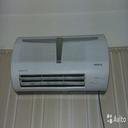

In [ ]:
import PIL
image_count = len(list(data_dir.glob('*/*.jpg')))
print("El repositorio de imagenes contiene: ", image_count, " elementos")

appliances = list(data_dir.glob('Appliances/*'))
PIL.Image.open(str(appliances[0]))
#19500  

In [ ]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir(data_dir)))
random.shuffle(imagePaths)
print(imagePaths)

['Motorcycles', 'Tablets and e-books', 'Goods for children and toys', 'Games, consoles and programs', 'Tech accessories', 'Repair and construction', 'Furniture and interior', 'Bicycles', 'Musical instruments', "Children's clothing and shoes", 'Clothes, shoes, accessories', 'Appliances', 'Audio and video', 'Phones']


In [ ]:
for img in imagePaths:
    path=sorted(list(os.listdir("/root/.keras/datasets/Dataset/"+img))) 
    for i in path:
        image = cv2.imread("/root/.keras/datasets/Dataset/"+img+'/'+i)
        image = cv2.resize(image, (128,128))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

In [ ]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 0 0 0 0 0 1 0 0 0 0 0]


In [ ]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.3,random_state=42)
print(xtrain.shape, xtest.shape)

(13650, 128, 128, 3) (5850, 128, 128, 3)


If the model sees no change in validation loss the ReduceLROnPlateau function will reduce the learning rate, which often benefits the model. The ImageDataGenerator function performs real-time data augmentation over generated tensor image data batches in a loop.

In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)

datagen.fit(xtrain)

In [ ]:
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=50,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.29805, saving model to model.h5
106/106 - 131s - loss: 2.1122 - accuracy: 0.4094 - val_loss: 1.2981 - val_accuracy: 0.5667 - lr: 0.0010 - 131s/epoch - 1s/step
Epoch 2/50

Epoch 2: val_loss improved from 1.29805 to 1.10873, saving model to model.h5
106/106 - 102s - loss: 1.5785 - accuracy: 0.4963 - val_loss: 1.1087 - val_accuracy: 0.6362 - lr: 0.0010 - 102s/epoch - 964ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.10873 to 1.03195, saving model to model.h5
106/106 - 100s - loss: 1.4328 - accuracy: 0.5290 - val_loss: 1.0319 - val_accuracy: 0.6675 - lr: 0.0010 - 100s/epoch - 944ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.03195 to 0.99698, saving model to model.h5
106/106 - 100s - loss: 1.3668 - accuracy: 0.5484 - val_loss: 0.9970 - val_accuracy: 0.6711 - lr: 0.0010 - 100s/epoch - 946ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.99698 to 0.95151, saving model to model.h5
106/106 - 100s - loss: 1.3061 - accuracy: 

In [ ]:
#Guardar modelo
model.save('/content/modelo1', save_format = 'h5')
!gsutil cp -r /content/modelo1 gs://tfmbucket1/models

Copying file:///content/modelo1 [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/46.2 MiB.                                     


In [ ]:
#Cargar el modelo
from tensorflow.keras.models import Sequential, load_model
# Importing saved model
output_dir =  '/content/'
model = load_model(output_dir + 'modelo1')

In [ ]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 5850 	accurately-predicted-data: 3785 	 wrongly-predicted-data:  2065
Accuracy: 64.701 %


In [2]:
print("139558")

139558


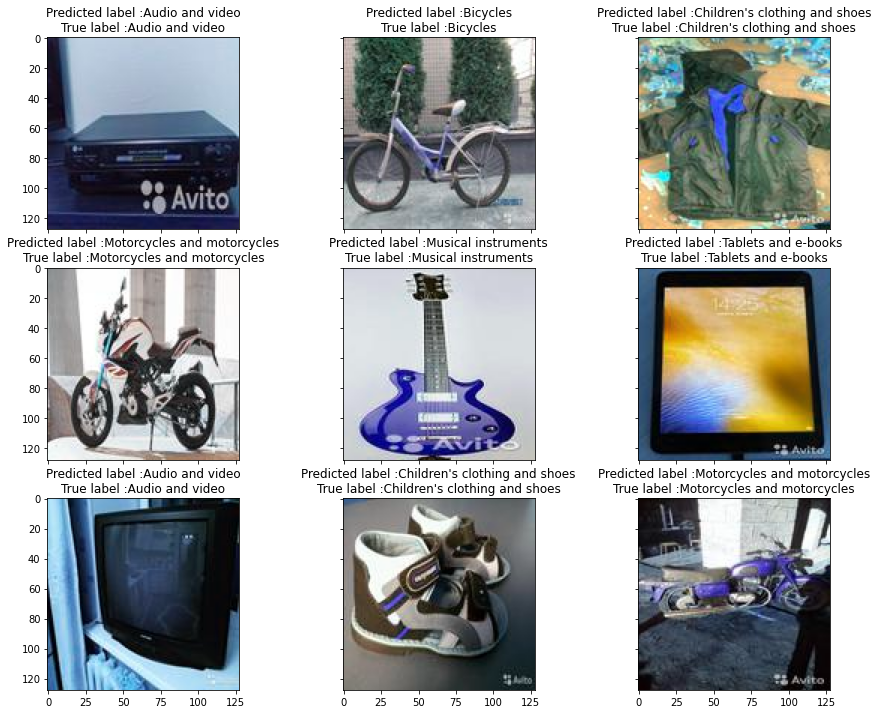

In [ ]:
label = ["Appliances",
         "Audio and video",
         "Bicycles",
         "Children's clothing and shoes",
         "Clothes, shoes, accessories",
         "Furniture and interior",
         "Games, consoles and programs",
         "Goods for children and toys",
         "Motorcycles and motorcycles",
         "Musical instruments",
         "Repair and construction",
         "Phones",
         "Tablets and e-books",
         "Tech accessories"]
         
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

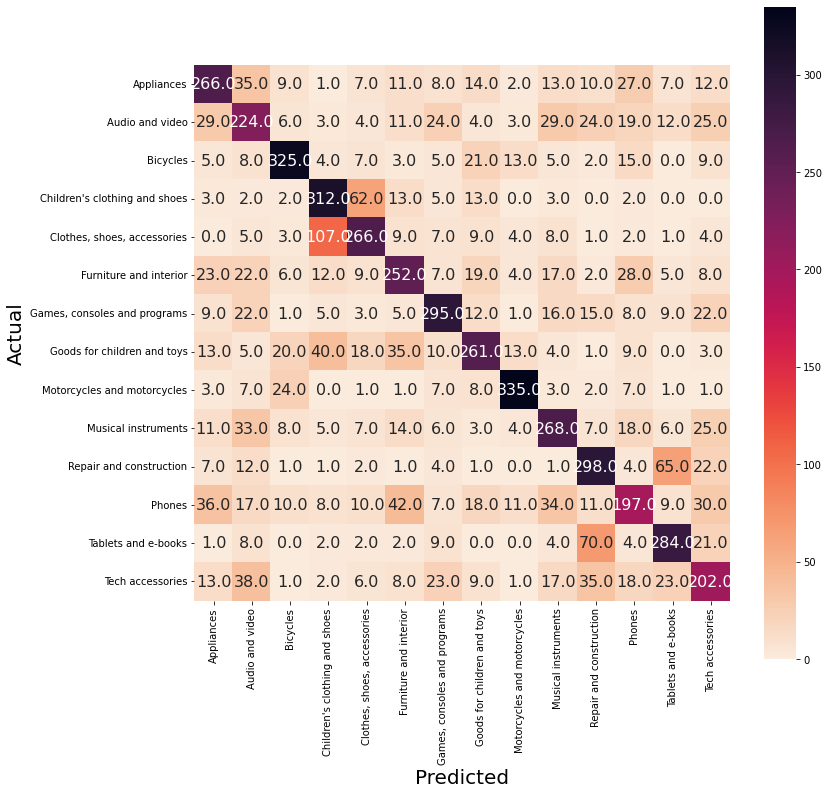

In [ ]:
Ypred = model.predict(xtest)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(ytest, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow

In [ ]:
#Ejecutar modelo
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import keras
import cv2
import numpy as np

modelo_imgcat = keras.models.load_model('/content/drive/MyDrive/TFM Big Data & BA/Propuestas/Proyecto Final/4 - Deep Learning/Modelos H5/Categorizacion_DenseNet201')
imagen = cv2.imread('/content/drive/MyDrive/TFM Big Data & BA/Propuestas/Proyecto Final/0 - Imagenes/ejemplo.jpg')

imagen = cv2.resize(imagen, (224, 224), interpolation=cv2.INTER_LINEAR)
imagen = np.asarray(imagen).reshape((1, 224, 224, 3))
y_prob = modelo_imgcat.predict(imagen)
y_classes = y_prob.argmax(axis = -1)